# Etiquetado de Opiniones por Subjetividad

Este notebook implementa un sistema de clasificaci√≥n autom√°tica de rese√±as tur√≠sticas en tres categor√≠as:
- **Objetiva**: contiene √∫nicamente hechos verificables
- **Subjetiva**: contiene opiniones, juicios personales o sentimientos 
- **Mixta**: combina hechos verificables con opiniones

Utilizamos LangChain con GPT-4o-mini para realizar la clasificaci√≥n con structured output.

## üí∞ Sistema Inteligente de Ahorro de API

El notebook incluye un **sistema autom√°tico de detecci√≥n de datos ya clasificados** que:

- ‚úÖ **Detecta autom√°ticamente** si ya existen clasificaciones previas
- üîÑ **Reutiliza datos existentes** sin volver a clasificar
- üÜï **Clasifica solo datos nuevos** (si los hay)
- üíæ **Combina inteligentemente** clasificaciones previas con nuevas
- üí∞ **Ahorra llamadas a la API** y reduce costos

### Opciones Disponibles:

1. **Usar datos existentes** - Sin costo de API
2. **Reejecutar clasificaci√≥n completa** - Procesa todo de nuevo
3. **Clasificar solo datos nuevos** - Procesamiento incremental

Esto te permite reejecutar el notebook sin preocuparte por gastar tu API key innecesariamente.

In [1]:
# Importaciones necesarias
import sys
import os

# A√±adir el directorio scripts al path para importar m√≥dulos personalizados
sys.path.append('../scripts')

# Importar m√≥dulo de etiquetado personalizado
from etiquetado import (
    configurar_entorno, validar_dependencias, verificar_api_key,
    cargar_datasets, configurar_clasificador, mostrar_comandos_utiles
)

# Configurar entorno de trabajo
configurar_entorno()

# Validar dependencias
if not validar_dependencias():
    print("‚ö†Ô∏è Instala las dependencias faltantes antes de continuar")
else:
    print("‚úÖ Importaciones y configuraci√≥n completadas exitosamente")

‚úÖ Entorno configurado exitosamente
‚úÖ Todas las dependencias est√°n instaladas
‚úÖ Importaciones y configuraci√≥n completadas exitosamente


In [2]:
# Verificaci√≥n inicial de estado de datos
import os

print("üîç VERIFICACI√ìN INICIAL DE DATOS")
print("=" * 40)

# Verificar si existen datos clasificados previos
archivo_clasificaciones = "../data/processed/reviews_clasificadas_subjetividad.csv"

if os.path.exists(archivo_clasificaciones):
    try:
        import pandas as pd
        df_previo = pd.read_csv(archivo_clasificaciones)
        
        print("‚úÖ Datos clasificados encontrados:")
        print(f"   üìä Total de rese√±as: {len(df_previo)}")
        
        if 'Ciudad' in df_previo.columns:
            conteo_ciudades = df_previo['Ciudad'].value_counts()
            for ciudad, count in conteo_ciudades.items():
                print(f"   üìç {ciudad}: {count} rese√±as")
        
        if 'Clasificacion_Subjetividad' in df_previo.columns:
            conteo_validas = len(df_previo[df_previo['Clasificacion_Subjetividad'] != 'Error'])
            print(f"   ‚úÖ Clasificaciones v√°lidas: {conteo_validas}")
            
        print("\nüí° El notebook detectar√° autom√°ticamente estos datos")
        print("üí∞ Solo se procesar√°n rese√±as nuevas (si las hay)")
            
    except Exception as e:
        print(f"‚ö†Ô∏è Error al leer datos existentes: {e}")
        
else:
    print("‚ÑπÔ∏è No se encontraron datos clasificados previos")
    print("üÜï Se procesar√°n todas las rese√±as desde cero")

print("\nüöÄ Procede a ejecutar las siguientes celdas...")

üîç VERIFICACI√ìN INICIAL DE DATOS
‚úÖ Datos clasificados encontrados:
   üìä Total de rese√±as: 1314
   üìç Cancun: 700 rese√±as
   üìç CDMX: 614 rese√±as
   ‚úÖ Clasificaciones v√°lidas: 1314

üí° El notebook detectar√° autom√°ticamente estos datos
üí∞ Solo se procesar√°n rese√±as nuevas (si las hay)

üöÄ Procede a ejecutar las siguientes celdas...


In [3]:
# Verificar configuraci√≥n de API
from etiquetado import SubjectivityClassification

# Verificar que la API key est√© configurada
if verificar_api_key():
    print("üîß Configuraci√≥n completada exitosamente")
    print("üìã Modelo de clasificaci√≥n disponible: SubjectivityClassification")
else:
    print("‚ùå Configuraci√≥n incompleta - verifica tu archivo .env")

‚úÖ API key de OpenAI cargada correctamente
üîß Configuraci√≥n completada exitosamente
üìã Modelo de clasificaci√≥n disponible: SubjectivityClassification


In [4]:
# Cargar datasets con verificaci√≥n de datos existentes
from etiquetado import verificar_datos_clasificados

print("üîç Verificando si ya existen clasificaciones previas...")

# Cargar datasets considerando datos existentes
resultado_carga = cargar_datasets(verificar_existentes=True)

# Desempaquetar resultado (puede ser una tupla de 3 elementos)
if isinstance(resultado_carga, tuple) and len(resultado_carga) == 3:
    df_reviews, df_existente, necesita_clasificacion = resultado_carga
    
    if df_existente is not None and not necesita_clasificacion:
        print("‚úÖ Usando datos existentes - No se requiere nueva clasificaci√≥n")
        print("üí∞ ¬°Ahorro de llamadas a la API!")
    elif df_reviews is not None and necesita_clasificacion:
        print(f"üìä Datos nuevos para clasificar: {len(df_reviews)} rese√±as")
        if df_existente is not None:
            print(f"üìö Datos existentes encontrados: {len(df_existente)} rese√±as")
    else:
        print("‚ùå No se pudieron cargar los datos")
else:
    # Resultado simple (backward compatibility)
    df_reviews = resultado_carga
    df_existente = None
    necesita_clasificacion = True
    
    if df_reviews is not None:
        print(f"\nüìã Muestra del dataset cargado:")
        print(df_reviews.head())
        print(f"\nüìà Distribuci√≥n por ciudad:")
        print(df_reviews['Ciudad'].value_counts())
    else:
        print("‚ùå No se pudieron cargar los datos")

üîç Verificando si ya existen clasificaciones previas...
‚úÖ Datos clasificados encontrados: ../data/processed/reviews_clasificadas_subjetividad.csv
üìä Total de rese√±as ya clasificadas: 1314
   üìç CDMX: 614 rese√±as
   üìç Cancun: 700 rese√±as
üîç Ciudades ya clasificadas encontradas: ['CDMX', 'Cancun']
‚úÖ Dataset Canc√∫n cargado: 700 registros
‚úÖ Dataset CDMX cargado: 614 registros
üìä Total de rese√±as √∫nicas para clasificar: 1314
‚úÖ Todas las ciudades ya est√°n clasificadas
üí∞ No se requieren llamadas adicionales a la API
‚úÖ Usando datos existentes - No se requiere nueva clasificaci√≥n
üí∞ ¬°Ahorro de llamadas a la API!


In [5]:
# Configurar clasificador usando el m√≥dulo de etiquetado
print("üîß Configurando clasificador GPT-4o-mini...")
clasificador = configurar_clasificador()

if clasificador is not None:
    print("‚úÖ Clasificador configurado exitosamente")
    print("üéØ Listo para clasificar rese√±as en categor√≠as de subjetividad")
else:
    print("‚ùå Error al configurar el clasificador")

üîß Configurando clasificador GPT-4o-mini...
‚úÖ Clasificador configurado exitosamente
üéØ Listo para clasificar rese√±as en categor√≠as de subjetividad
‚úÖ Clasificador configurado exitosamente
üéØ Listo para clasificar rese√±as en categor√≠as de subjetividad


In [6]:
# Importar funciones de clasificaci√≥n del m√≥dulo
from etiquetado import clasificar_reviews, limpiar_checkpoint

# Verificar que tenemos datos y clasificador antes de proceder
if df_reviews is not None and clasificador is not None:
    print(f"‚úÖ Datos cargados: {len(df_reviews)} rese√±as √∫nicas")
    print(f"‚úÖ Clasificador configurado correctamente")

    # Mostrar funciones disponibles
    funciones_disponibles = [
        "clasificar_reviews(df, clasificador) - Clasificar todas las rese√±as",
        "limpiar_checkpoint() - Limpiar progreso guardado"
    ]
    print("\nFunciones disponibles:")
    for funcion in funciones_disponibles:
        print(f"   ‚Ä¢ {funcion}")

    # Mostrar comandos √∫tiles
    mostrar_comandos_utiles()
else:
    print("‚ùå Faltan datos o configuraci√≥n del clasificador")
    print("‚ÑπÔ∏è Ejecuta las celdas anteriores para cargar datos y configurar el clasificador")

‚ùå Faltan datos o configuraci√≥n del clasificador
‚ÑπÔ∏è Ejecuta las celdas anteriores para cargar datos y configurar el clasificador


In [7]:
# Gesti√≥n de checkpoints usando el m√≥dulo
from etiquetado import verificar_checkpoint, reiniciar_clasificacion

# Verificar estado del checkpoint actual
print("üîç Verificando estado del checkpoint...")
checkpoint_existe, checkpoint_data = verificar_checkpoint()

print(f"\nüí° COMANDOS DE GESTI√ìN DISPONIBLES:")
print(f"   ‚Ä¢ verificar_checkpoint() - Ver estado del progreso guardado")
print(f"   ‚Ä¢ reiniciar_clasificacion() - Limpiar progreso y empezar de nuevo")
print(f"   ‚Ä¢ limpiar_checkpoint() - Eliminar archivo de progreso")

üîç Verificando estado del checkpoint...
‚ÑπÔ∏è No hay checkpoint guardado

üí° COMANDOS DE GESTI√ìN DISPONIBLES:
   ‚Ä¢ verificar_checkpoint() - Ver estado del progreso guardado
   ‚Ä¢ reiniciar_clasificacion() - Limpiar progreso y empezar de nuevo
   ‚Ä¢ limpiar_checkpoint() - Eliminar archivo de progreso


In [8]:
# Ejecutar clasificaci√≥n inteligente (evita reprocesar datos existentes)
from etiquetado import proceso_completo_clasificacion

# Verificar qu√© datos tenemos disponibles
tiene_datos = (df_reviews is not None) or (df_existente is not None)
tiene_clasificador = clasificador is not None

if tiene_datos and tiene_clasificador:
    
    # Determinar estrategia basada en lo que se carg√≥
    if 'necesita_clasificacion' in locals():
        if not necesita_clasificacion and df_existente is not None:
            print("üéØ Usando datos existentes - Sin costo de API")
            print("‚úÖ Saltando clasificaci√≥n porque ya est√° completa")
            
            # Usar datos existentes directamente
            df_clasificado = df_existente
            df_analizado = None  # Se analizar√° en la siguiente celda
            guardado_exitoso = True
            
            print("üìä Datos disponibles para an√°lisis y visualizaci√≥n")
            
        else:
            print("üéØ Iniciando proceso de clasificaci√≥n inteligente...")
            print("üí° Solo se procesar√°n datos nuevos (si los hay)")
            print("üí∞ Se evitar√° reprocesar datos ya clasificados")
            
            if df_existente is not None:
                print(f"üìö Reutilizando {len(df_existente)} clasificaciones existentes")
            if df_reviews is not None:
                print(f"üÜï Clasificando {len(df_reviews)} rese√±as nuevas")
            
            print("‚ö†Ô∏è Este proceso puede tomar varios minutos para datos nuevos")
            print("üíæ El progreso se guarda autom√°ticamente")
            print("üõë Puedes interrumpir con Ctrl+C sin perder el progreso")
            
            # Ejecutar proceso con datos existentes
            try:
                df_clasificado, df_analizado, guardado_exitoso = proceso_completo_clasificacion(
                    df_reviews,           # Solo datos nuevos
                    clasificador, 
                    df_existente,         # Datos existentes para combinar
                    batch_size=10,        # Mostrar progreso cada 10 rese√±as
                    save_frequency=50     # Guardar cada 50 rese√±as
                )
                
                if df_clasificado is not None:
                    print("\n‚úÖ ¬°Proceso completado exitosamente!")
                    
                    # Mostrar ejemplos de clasificaciones
                    print("\nüîç Ejemplos de clasificaciones (incluyendo existentes):")
                    ejemplos = df_clasificado[['TituloReview', 'Ciudad', 'Clasificacion_Subjetividad']].head(5)
                    for idx, row in ejemplos.iterrows():
                        review_short = row['TituloReview'][:80] + "..." if len(row['TituloReview']) > 80 else row['TituloReview']
                        print(f"  üìù {row['Ciudad']}: {review_short}")
                        print(f"     üè∑Ô∏è Clasificaci√≥n: {row['Clasificacion_Subjetividad']}")
                        print()
                
            except KeyboardInterrupt:
                print("\nüõë Proceso interrumpido por el usuario")
                print("üíæ El progreso ha sido guardado autom√°ticamente")
                
            except Exception as e:
                print(f"\n‚ùå Error inesperado: {e}")
    else:
        # M√©todo tradicional (fallback)
        print("üîÑ Usando m√©todo tradicional de clasificaci√≥n...")
        df_clasificado, df_analizado, guardado_exitoso = proceso_completo_clasificacion(
            df_reviews, clasificador
        )
        
else:
    if not tiene_datos:
        print("‚ùå No se puede proceder: faltan datos para clasificar")
        print("üí° Ejecuta las celdas anteriores para cargar los datos")
    if not tiene_clasificador:
        print("‚ùå No se puede proceder: falta configuraci√≥n del clasificador")
        print("üí° Ejecuta las celdas anteriores para configurar el clasificador")

üéØ Usando datos existentes - Sin costo de API
‚úÖ Saltando clasificaci√≥n porque ya est√° completa
üìä Datos disponibles para an√°lisis y visualizaci√≥n


In [9]:
# An√°lisis estad√≠stico usando el m√≥dulo de etiquetado
from etiquetado import analizar_resultados

# Verificar si tenemos datos clasificados
if 'df_clasificado' in locals() and df_clasificado is not None:
    print("üìä Iniciando an√°lisis estad√≠stico de los resultados...")
    try:
        df_analizado = analizar_resultados(df_clasificado)
        if df_analizado is not None:
            print("‚úÖ An√°lisis completado exitosamente")
        else:
            print("‚ö†Ô∏è No se generaron resultados del an√°lisis")
    except Exception as e:
        print(f"‚ùå Error durante el an√°lisis: {e}")
else:
    print("‚ö†Ô∏è No hay datos clasificados disponibles para analizar")
    print("‚ÑπÔ∏è Aseg√∫rate de ejecutar la celda de clasificaci√≥n primero")

üìä Iniciando an√°lisis estad√≠stico de los resultados...
üìä AN√ÅLISIS DE RESULTADOS DE CLASIFICACI√ìN
üìà Total de rese√±as analizadas: 1314
‚ùå Rese√±as con errores: 0

üè∑Ô∏è DISTRIBUCI√ìN GENERAL DE CLASIFICACIONES:
   Objetiva  :   14 rese√±as (  1.1%)
   Subjetiva :  369 rese√±as ( 28.1%)
   Mixta     :  931 rese√±as ( 70.9%)

üåé DISTRIBUCI√ìN POR CIUDAD:

  üìç Cancun:
     Objetiva  :   10 rese√±as (  1.4%)
     Subjetiva :  220 rese√±as ( 31.4%)
     Mixta     :  470 rese√±as ( 67.1%)

  üìç CDMX:
     Objetiva  :    4 rese√±as (  0.7%)
     Subjetiva :  149 rese√±as ( 24.3%)
     Mixta     :  461 rese√±as ( 75.1%)
‚úÖ An√°lisis completado exitosamente


üìà Generando visualizaciones de los resultados...


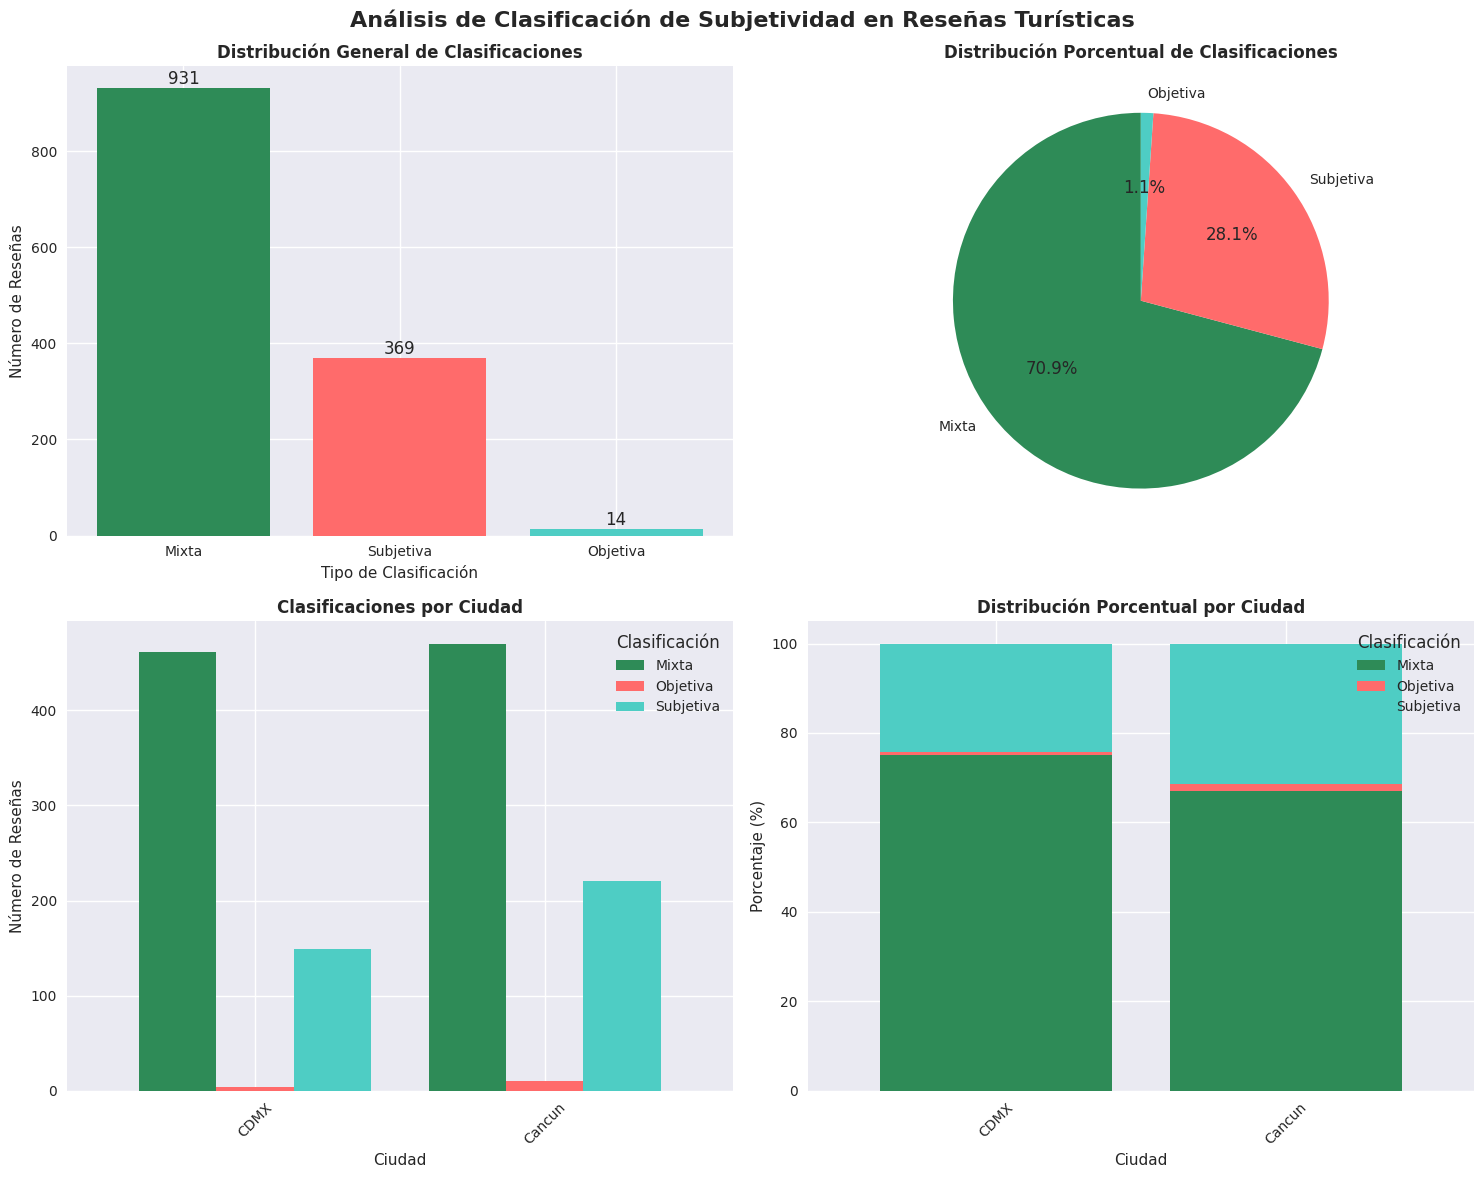

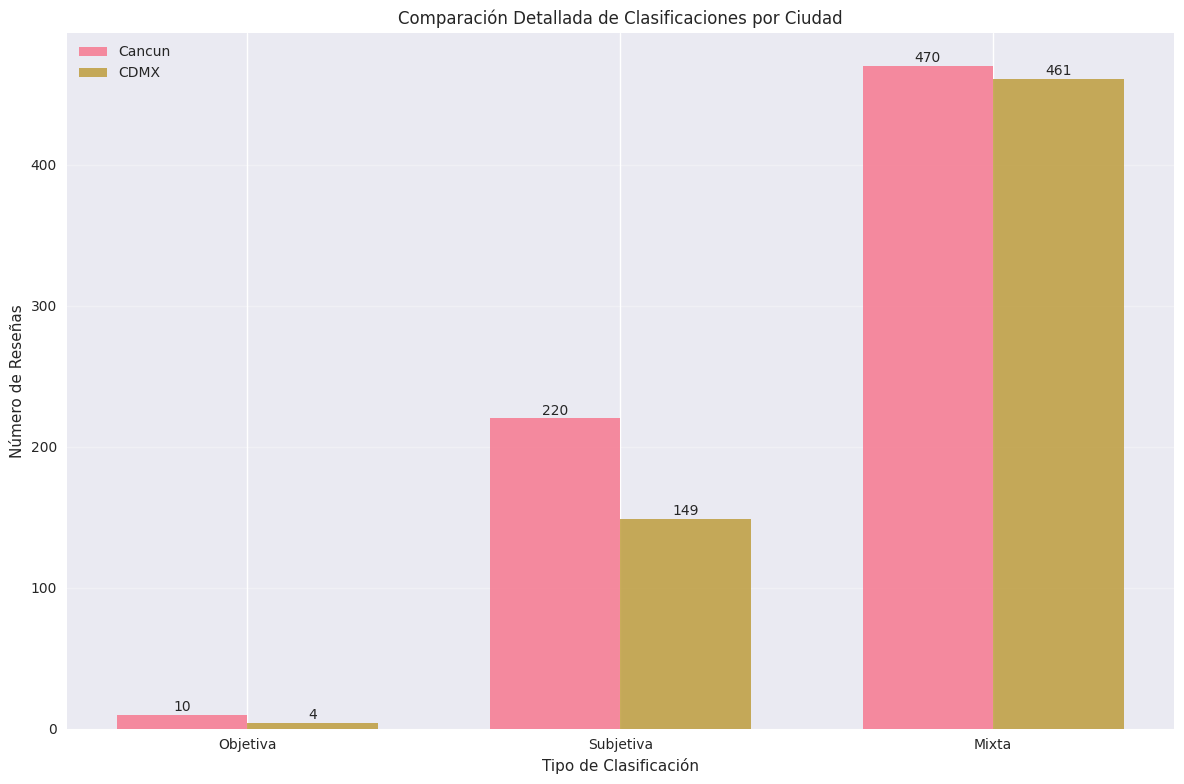

üìä Visualizaciones generadas exitosamente
‚úÖ Visualizaciones generadas exitosamente

üí° Tambi√©n puedes usar:
   ‚Ä¢ crear_grafico_simple(df_analizado, 'barras') - Gr√°fico simple de barras
   ‚Ä¢ crear_grafico_simple(df_analizado, 'pastel') - Gr√°fico simple de pastel


In [10]:
# Visualizaciones usando el m√≥dulo de etiquetado
from etiquetado import crear_visualizaciones, crear_grafico_simple

# Verificar si tenemos datos analizados
if 'df_analizado' in locals() and df_analizado is not None:
    print("üìà Generando visualizaciones de los resultados...")
    
    # Crear visualizaciones completas
    crear_visualizaciones(df_analizado)
    
    print("‚úÖ Visualizaciones generadas exitosamente")
    print("\nüí° Tambi√©n puedes usar:")
    print("   ‚Ä¢ crear_grafico_simple(df_analizado, 'barras') - Gr√°fico simple de barras")
    print("   ‚Ä¢ crear_grafico_simple(df_analizado, 'pastel') - Gr√°fico simple de pastel")
    
else:
    print("‚ö†Ô∏è No hay datos analizados disponibles para visualizar")
    print("üí° Ejecuta primero las celdas de clasificaci√≥n y an√°lisis")

In [11]:
# Guardado inteligente y resumen final
from etiquetado import guardar_resultados, generar_resumen_final, generar_reporte_completo, exportar_estadisticas_json

# Verificar si tenemos datos para guardar
if 'df_clasificado' in locals() and df_clasificado is not None:
    
    # Verificar si ya se guard√≥ en el proceso autom√°tico
    if 'guardado_exitoso' in locals() and guardado_exitoso:
        print("‚úÖ Los resultados ya fueron guardados autom√°ticamente")
    else:
        print("üíæ Guardando resultados...")
        
        # Determinar si hay datos existentes para combinar
        df_previos = df_existente if 'df_existente' in locals() else None
        guardado_exitoso = guardar_resultados(df_clasificado, df_previos)
    
    # Generar an√°lisis si no se hizo autom√°ticamente
    if 'df_analizado' not in locals() or df_analizado is None:
        print("\nüìä Generando an√°lisis de datos completos...")
        from etiquetado import analizar_resultados
        df_analizado = analizar_resultados(df_clasificado)
    
    # Generar resumen final si tenemos an√°lisis
    if df_analizado is not None:
        print("\nüìã Generando resumen final...")
        generar_resumen_final(df_analizado)
        
        # Opciones adicionales de exportaci√≥n
        print("\nüìÑ Generando reporte completo...")
        generar_reporte_completo(df_clasificado, df_analizado)
        
        print("\nüìä Exportando estad√≠sticas en formato JSON...")
        exportar_estadisticas_json(df_analizado)
        
        print("\n‚úÖ Todos los archivos generados exitosamente")
        
        # Mostrar resumen de ahorro
        if 'df_existente' in locals() and df_existente is not None:
            total_existentes = len(df_existente)
            total_nuevas = len(df_clasificado) - total_existentes if len(df_clasificado) > total_existentes else 0
            
            print(f"\nüí∞ RESUMEN DE EFICIENCIA:")
            print(f"   üìö Rese√±as reutilizadas: {total_existentes}")
            print(f"   üÜï Rese√±as nuevas clasificadas: {total_nuevas}")
            print(f"   üíµ Llamadas a API ahorradas: ~{total_existentes}")
    
else:
    print("‚ö†Ô∏è No hay datos clasificados para guardar")
    print("üí° Ejecuta primero las celdas de clasificaci√≥n")

‚úÖ Los resultados ya fueron guardados autom√°ticamente

üìã Generando resumen final...
üéØ RESUMEN FINAL DEL PROCESO DE CLASIFICACI√ìN
üìä Total de rese√±as procesadas: 1314

üè∑Ô∏è RESULTADOS DE CLASIFICACI√ìN:
   Objetiva  :   14 rese√±as (  1.1%)
   Subjetiva :  369 rese√±as ( 28.1%)
   Mixta     :  931 rese√±as ( 70.9%)

üîç INSIGHTS PRINCIPALES:
   ‚Ä¢ La categor√≠a predominante es 'Mixta' con 70.9% del total
   ‚Ä¢ Las rese√±as tur√≠sticas tienden a combinar hechos con opiniones (mixtas)

üåé COMPARACI√ìN POR CIUDAD:
   üìç Cancun: Predomina 'Mixta' (67.1%)
   üìç CDMX: Predomina 'Mixta' (75.1%)

‚úÖ Proceso de clasificaci√≥n completado exitosamente

üìÑ Generando reporte completo...
‚úÖ Reporte completo guardado en: ../data/processed/reporte_clasificacion.txt

üìä Exportando estad√≠sticas en formato JSON...
‚úÖ Estad√≠sticas exportadas a: ../data/processed/estadisticas_clasificacion.json

‚úÖ Todos los archivos generados exitosamente

üí∞ RESUMEN DE EFICIENCIA:
   ü

# # Celda de prueba r√°pida usando el m√≥dulo de etiquetado
# from etiquetado import prueba_rapida

# # Funci√≥n de prueba disponible
# def ejecutar_prueba_rapida(n_samples=5):
#     """Ejecuta una prueba r√°pida con pocas rese√±as"""
#     if df_reviews is not None and clasificador is not None:
#         return prueba_rapida(df_reviews, clasificador, n_samples)
#     else:
#         print("‚ùå Faltan datos o clasificador")
#         return None

# print("ÔøΩ Celda de prueba r√°pida configurada")
# print("üí° Uso: df_prueba = ejecutar_prueba_rapida(5)")
# print("ÔøΩÔ∏è Ideal para verificar funcionamiento antes del proceso completo")

# # Descomenta la siguiente l√≠nea para ejecutar una prueba con 5 rese√±as
# # df_prueba = ejecutar_prueba_rapida(5)
# print("‚ö†Ô∏è Celda de prueba r√°pida comentada para evitar ejecuciones accidentales")

In [12]:
# Mostrar opiniones por categor√≠a usando el m√≥dulo de etiquetado
from etiquetado import mostrar_opiniones_por_categoria

# Verificar si hay datos clasificados
if 'df_clasificado' in locals() and df_clasificado is not None:
    try:
        print("üìã Mostrando opiniones clasificadas por categor√≠a...")
        mostrar_opiniones_por_categoria(df_clasificado)
        print("‚úÖ Opiniones mostradas exitosamente")
    except Exception as e:
        print(f"‚ùå Error al mostrar opiniones: {e}")
else:
    print("‚ö†Ô∏è No hay datos clasificados disponibles para mostrar")
    print("‚ÑπÔ∏è Aseg√∫rate de ejecutar la celda de clasificaci√≥n primero")

üìã Mostrando opiniones clasificadas por categor√≠a...
üìã Opiniones clasificadas por categor√≠a:

üè∑Ô∏è Objetiva:
   1. Buena ubicaci√≥n Ubicacion conveniente. V√≠a principal, f√°cil acceso a rutas de buses locales, lugares tur√≠sticos, centros comerciales, restaurantes, actividades y hoteles.
   2. Un s√≠mbolo de la zona hotelera y de todo Canc√∫n La avenida Kukulc√°n a lo largo de sus 26 kms. une todos los hoteles de la zona hotelera de norte a sur, inicia saliendo de Canc√∫n y termina cerca del acceso al aeropuerto. Las numerosas l√≠neas de "camiones" (√≥mnibus) trasladan a los turistas de los hoteles m√°s distantes a la zona m√°s c√©ntrica y viceversa.
   3. Conexiones Esta avenida conecta la zona hotelera, shoppings, casas de cambio, propuestas gastron√≥micas y de entretenimiento.Se puede pasear caminando o recorrerla en los buses que pasan continuamente.
   4. V√≠a arter√≠a Es la principal avenida junto a la playa por la cual se llegan a las principales playas p√∫blicas, cen

In [13]:
# Resumen de funciones disponibles del m√≥dulo de etiquetado
print("üìö RESUMEN DE FUNCIONES DISPONIBLES")
print("=" * 50)

print("\nüîß CONFIGURACI√ìN:")
print("   ‚Ä¢ configurar_entorno() - Configurar matplotlib y suprimir warnings")
print("   ‚Ä¢ validar_dependencias() - Verificar que todas las librer√≠as est√©n instaladas")
print("   ‚Ä¢ verificar_api_key() - Verificar configuraci√≥n de OpenAI API")
print("   ‚Ä¢ configurar_clasificador() - Configurar modelo GPT-4o-mini")

print("\nüìÅ CARGA DE DATOS:")
print("   ‚Ä¢ cargar_datasets() - Cargar datasets de Canc√∫n y CDMX")
print("   ‚Ä¢ cargar_muestra_prueba(df, n) - Crear muestra peque√±a para pruebas")

print("\nüè∑Ô∏è CLASIFICACI√ìN:")
print("   ‚Ä¢ clasificar_reviews(df, clasificador) - Clasificar todas las rese√±as")
print("   ‚Ä¢ prueba_rapida(df, clasificador, n) - Prueba con pocas rese√±as")
print("   ‚Ä¢ verificar_checkpoint() - Ver progreso guardado")
print("   ‚Ä¢ limpiar_checkpoint() - Eliminar progreso guardado")
print("   ‚Ä¢ reiniciar_clasificacion() - Reiniciar desde el principio")

print("\nüìä AN√ÅLISIS:")
print("   ‚Ä¢ analizar_resultados(df) - An√°lisis estad√≠stico completo")
print("   ‚Ä¢ mostrar_opiniones_por_categoria(df) - Ver opiniones por categor√≠a")
print("   ‚Ä¢ obtener_estadisticas_resumidas(df) - Estad√≠sticas en formato dict")

print("\nüìà VISUALIZACI√ìN:")
print("   ‚Ä¢ crear_visualizaciones(df) - Gr√°ficos completos")
print("   ‚Ä¢ crear_grafico_simple(df, tipo) - Gr√°fico simple ('barras' o 'pastel')")
print("   ‚Ä¢ configurar_estilo_graficos() - Configurar estilo matplotlib")

print("\nüíæ GUARDADO:")
print("   ‚Ä¢ guardar_resultados(df) - Guardar CSV con clasificaciones")
print("   ‚Ä¢ generar_resumen_final(df) - Resumen en consola")
print("   ‚Ä¢ generar_reporte_completo(df1, df2) - Reporte completo en TXT")
print("   ‚Ä¢ exportar_estadisticas_json(df) - Estad√≠sticas en JSON")

print("\nüöÄ PROCESO COMPLETO:")
print("   ‚Ä¢ proceso_completo_clasificacion(df, clasificador) - Ejecuta todo el pipeline")

print("\nüí° UTILIDADES:")
print("   ‚Ä¢ mostrar_comandos_utiles() - Mostrar comandos principales")
print("   ‚Ä¢ obtener_info_sistema() - Informaci√≥n del sistema para debugging")

print("\n‚úÖ Todas las funciones est√°n disponibles tras importar el m√≥dulo 'etiquetado'")

üìö RESUMEN DE FUNCIONES DISPONIBLES

üîß CONFIGURACI√ìN:
   ‚Ä¢ configurar_entorno() - Configurar matplotlib y suprimir warnings
   ‚Ä¢ validar_dependencias() - Verificar que todas las librer√≠as est√©n instaladas
   ‚Ä¢ verificar_api_key() - Verificar configuraci√≥n de OpenAI API
   ‚Ä¢ configurar_clasificador() - Configurar modelo GPT-4o-mini

üìÅ CARGA DE DATOS:
   ‚Ä¢ cargar_datasets() - Cargar datasets de Canc√∫n y CDMX
   ‚Ä¢ cargar_muestra_prueba(df, n) - Crear muestra peque√±a para pruebas

üè∑Ô∏è CLASIFICACI√ìN:
   ‚Ä¢ clasificar_reviews(df, clasificador) - Clasificar todas las rese√±as
   ‚Ä¢ prueba_rapida(df, clasificador, n) - Prueba con pocas rese√±as
   ‚Ä¢ verificar_checkpoint() - Ver progreso guardado
   ‚Ä¢ limpiar_checkpoint() - Eliminar progreso guardado
   ‚Ä¢ reiniciar_clasificacion() - Reiniciar desde el principio

üìä AN√ÅLISIS:
   ‚Ä¢ analizar_resultados(df) - An√°lisis estad√≠stico completo
   ‚Ä¢ mostrar_opiniones_por_categoria(df) - Ver opiniones por ca